### In-Class Exercise 1: Load the clean communitiy crime data

- Create a dataframe for predictor and response variables
- Scale the predictor variables as done in Feature Engineering 1 - Principal Components


In [34]:
from sklearn.manifold import TSNE

# Data processing and functions
import pandas as pd
import numpy as np
import scipy as sp

# Analytics and modeling
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn import manifold
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import make_pipeline
import statsmodels.api as sm
import statsmodels.sandbox.tools.tools_pca as sm_pca
from statsmodels.formula.api import ols as sm_ols
from statsmodels.stats.anova import anova_lm as sm_anova
from patsy.contrasts import Treatment
from patsy import dmatrices

# Graphing and visualizing
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
from pylab import savefig

# Setting graphing preferences
sns.set(style="darkgrid", color_codes=True)

# Printing
import locale

# Show plots locally
locale.setlocale( locale.LC_ALL, '' )

%matplotlib inline

In [35]:
# Load our data
path = "/Users/mead/Fall2017/DonBrown-DS6001/FeatureEngineering/"

file = "CrimeDataClean.csv"

label = "CrimeVariableLabels.txt"

# DATA
crime_df_clean = pd.read_csv(path + file, low_memory = False)

In [36]:
# Divide up into predictors and responses
predictors = crime_df_clean.columns[:101]
response = crime_df_clean.columns[102:]

In [47]:
# Standardize by removing the raw crime counts (want just PerPop)
response_start = crime_df_clean.columns.get_loc('murders')
# Just using pattern information to extract these columns more easily
cols = list(range(response_start + 1, 118, 2))
cols.extend([118,119])

In [48]:
# Get response df
crime_resp_df = crime_df_clean[crime_df_clean.columns[cols]]

# Get the predicted df
crime_pred_df = crime_df_clean.loc[:, :'LemasPctOfficDrugUn']
crime_pred_df.shape

(2215, 102)

In [38]:
# Pick the columns we need to scale
crime_pred_df.describe()
# Some of these are percentages; only need to scale the one with ranges 

preds2scale = crime_pred_df.columns[crime_pred_df.apply('max', axis = 0) > 1000]
print(preds2scale)
preds2notscale = crime_pred_df.columns[crime_pred_df.apply('max', axis = 0) < 1000]
print(preds2notscale)

Index([u'population', u'numbUrban', u'medIncome', u'medFamInc', u'perCapInc',
       u'whitePerCap', u'blackPerCap', u'indianPerCap', u'AsianPerCap',
       u'OtherPerCap', u'HispPerCap', u'NumUnderPov', u'NumKidsBornNeverMar',
       u'NumImmig', u'HousVacant', u'MedYrHousBuilt', u'OwnOccLowQuart',
       u'OwnOccMedVal', u'OwnOccHiQuart', u'OwnOccQrange', u'RentLowQ',
       u'RentMedian', u'RentHighQ', u'MedRent', u'NumInShelters', u'NumStreet',
       u'LandArea', u'PopDens'],
      dtype='object')
Index([u'householdsize', u'racepctblack', u'racePctWhite', u'racePctAsian',
       u'racePctHisp', u'agePct12t21', u'agePct12t29', u'agePct16t24',
       u'agePct65up', u'pctUrban', u'pctWWage', u'pctWFarmSelf', u'pctWInvInc',
       u'pctWSocSec', u'pctWPubAsst', u'pctWRetire', u'PctPopUnderPov',
       u'PctLess9thGrade', u'PctNotHSGrad', u'PctBSorMore', u'PctUnemployed',
       u'PctEmploy', u'PctEmplManu', u'PctEmplProfServ', u'PctOccupManu',
       u'PctOccupMgmtProf', u'MalePctDivo

In [39]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,100))


# Acctually perform the scaling
scaled_df = pd.DataFrame(scaler.fit_transform(crime_pred_df[preds2scale]),
                        columns = preds2scale)

scaled_df.describe()

,population,numbUrban,medIncome,medFamInc,perCapInc,whitePerCap,blackPerCap,indianPerCap,AsianPerCap,OtherPerCap,...,OwnOccHiQuart,OwnOccQrange,RentLowQ,RentMedian,RentHighQ,MedRent,NumInShelters,NumStreet,LandArea,PopDens
count,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,...,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000
mean,0.589575,0.651885,21.888215,22.876343,17.853310,17.507177,5.441142,2.547748,13.401770,6.892115,...,24.823656,17.106482,25.606052,35.021254,42.155412,38.252950,0.286334,0.170609,0.743085,6.272821
std,2.798203,2.807851,11.698150,11.085170,10.818150,10.014264,4.352302,3.094549,9.307461,5.784468,...,20.989975,11.814652,15.979874,19.376464,24.333429,20.923577,2.413091,2.349503,3.077211,6.397557
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.059637,0.000000,13.028172,14.849760,10.962714,11.263372,3.178625,1.321875,7.804361,4.035401,...,9.771069,9.728097,12.694013,19.239501,22.466422,21.260816,0.000000,0.000000,0.179327,2.650164
50%,0.174864,0.246375,19.671660,20.403544,15.265651,15.148790,4.609183,2.061458,11.538643,5.975182,...,16.638371,13.111782,23.059867,31.441544,37.118437,33.992583,0.000000,0.000000,0.358654,4.561973
75%,0.451538,0.572450,28.419993,28.431639,21.627486,20.728802,6.848011,3.074479,16.321292,8.412409,...,33.870212,19.773414,35.698448,48.127128,58.302808,52.286774,0.094085,0.009572,0.706100,7.489162
max,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000


In [40]:
# And combine with the unscaled columns
pred_scaled_df = pd.concat([scaled_df, crime_pred_df[preds2notscale]], axis=1)

In [41]:
pred_scaled_df.shape

(2215, 102)

In [45]:
crimes_scaled_preds_df = pred_scaled_df
crimes_scaled_preds_df.describe()

,population,numbUrban,medIncome,medFamInc,perCapInc,whitePerCap,blackPerCap,indianPerCap,AsianPerCap,OtherPerCap,...,MedRentPctHousInc,MedOwnCostPctInc,MedOwnCostPctIncNoMtg,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,PctUsePubTrans,LemasPctOfficDrugUn
count,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,...,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000
mean,0.589575,0.651885,21.888215,22.876343,17.853310,17.507177,5.441142,2.547748,13.401770,6.892115,...,26.298104,20.990158,13.010203,7.340302,61.539630,51.538596,77.411079,88.111865,3.041124,0.980163
std,2.798203,2.807851,11.698150,11.085170,10.818150,10.014264,4.352302,3.094549,9.307461,5.784468,...,2.979297,2.987622,1.419679,8.418476,16.750061,10.517926,10.878186,7.287836,4.912917,2.877128
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,14.900000,14.000000,10.100000,0.180000,6.750000,11.830000,27.950000,32.830000,0.000000,0.000000
25%,0.059637,0.000000,13.028172,14.849760,10.962714,11.263372,3.178625,1.321875,7.804361,4.035401,...,24.300000,18.700000,12.000000,2.060000,50.110000,44.995000,72.060000,85.200000,0.360000,0.000000
50%,0.174864,0.246375,19.671660,20.403544,15.265651,15.148790,4.609183,2.061458,11.538643,5.975182,...,26.100000,21.000000,12.800000,4.310000,64.490000,52.170000,79.490000,90.030000,1.220000,0.000000
75%,0.451538,0.572450,28.419993,28.431639,21.627486,20.728802,6.848011,3.074479,16.321292,8.412409,...,28.000000,23.100000,13.700000,9.250000,74.855000,58.740000,85.135000,93.010000,3.365000,0.000000
max,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,35.100000,32.700000,23.400000,60.400000,93.140000,78.560000,96.590000,99.900000,54.330000,48.440000


### In-Class Exercise 2 

- Get two tSNE components for the scaled predictors using the default values for the hyperparameters
- Plot the observations in these components
- Plot the observations in these components with the violent crimes cut using the box plot statistics
- Plot the observations in these components with the nonviolent crimes cut using the box plot statistics
- Plot the observations in these components with one of the other response variables

In [43]:
# tsne 

# Get two components for plotting
components = 2

tsne = TSNE(n_components= components, init='random',
                         random_state=42)

crimes_tsne = tsne.fit_transform(crimes_scaled_preds_df)

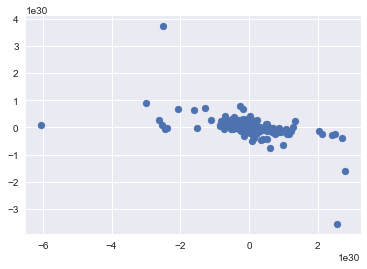

In [44]:
plt.scatter(crimes_tsne[:,0], crimes_tsne[:,1])

[0.0, 185.28, 374.06, 722.0, 1523.9200000000001]


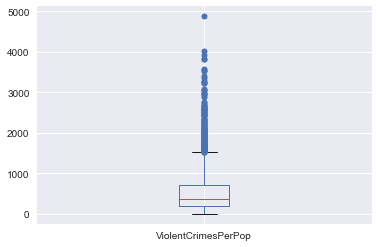

In [46]:
# Doing the first two PC scatterplots with ViolentCrimesPerPop as the binned response
violent_box = crime_resp_df.boxplot(column = 'ViolentCrimesPerPop',
                                   return_type = 'dict', sym = 'b')

violent_box_bounds = [violent_box['whiskers'][0].get_ydata()[1], # lower whisker
                    violent_box['boxes'][0].get_ydata()[0],      # lower box 25%
                    violent_box['medians'][0].get_ydata()[0],    # median
                    violent_box['boxes'][0].get_ydata()[2],      # upper box 75%
                    violent_box['whiskers'][1].get_ydata()[1]]   # upper whisker

print(violent_box_bounds)

In [49]:
# Now need to make a new column to correctly take care 
# of each of these boundary points and label our data by violent crime rates
crime_levels = ['Great', 'Okay', 'Neutral', 'Bad', 'Abyssmal']

# And now bin the data
bins = violent_box_bounds
bins.append(crime_resp_df['ViolentCrimesPerPop'].max())

In [50]:
# Now use pd.cut to break the Violent Crimes into the different labels that we created above based on their bins
Violent = pd.cut(crime_resp_df['ViolentCrimesPerPop'], bins, labels = crime_levels)

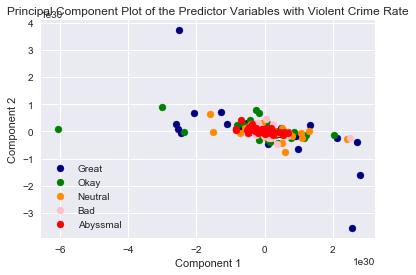

In [52]:
# PCA plot with labels for Violent Crime levels
colors = ['navy', 'green', 'darkorange', 'pink', 'red']

fig, ax = plt.subplots()
for i, color in  zip(crime_levels, colors):
        ax.scatter(crimes_tsne[Violent == i, 0],
                   crimes_tsne[Violent == i, 1], c = color, label=i)


ax.legend(loc = 3)
ax.grid(True)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title('Principal Component Plot of the Predictor Variables with Violent Crime Rate')


### In-Class Exercise 3 

- Get two tSNE components for the scaled predictors using perplexity values of 5 and 100
- Plot the observations in these components
- Plot the observations in these components with the violent crimes cut using the box plot statistics
- Plot the observations in these components with the nonviolent crimes cut using the box plot statistics
- Plot the observations in these components with one of the other response variables

In [53]:
# tsne 

# Get two components for plotting
components = 2

tsne = TSNE(n_components= components, init='random',
                         random_state=42, perplexity = 5)

crimes_tsne = tsne.fit_transform(crimes_scaled_preds_df)

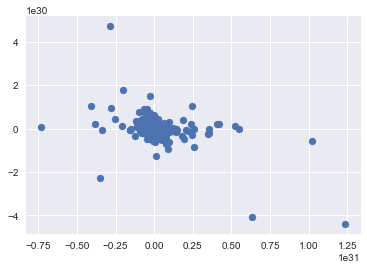

In [54]:
plt.scatter(crimes_tsne[:,0], crimes_tsne[:,1])

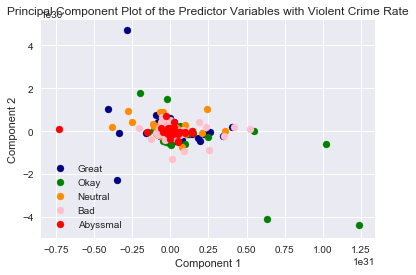

In [55]:
# PCA plot with labels for Violent Crime levels
colors = ['navy', 'green', 'darkorange', 'pink', 'red']

fig, ax = plt.subplots()
for i, color in  zip(crime_levels, colors):
        ax.scatter(crimes_tsne[Violent == i, 0],
                   crimes_tsne[Violent == i, 1], c = color, label=i)


ax.legend(loc = 3)
ax.grid(True)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title('Principal Component Plot of the Predictor Variables with Violent Crime Rate')


In [56]:
# tsne 

# Get two components for plotting
components = 2

tsne = TSNE(n_components= components, init='random',
                         random_state=42, perplexity = 100)

crimes_tsne = tsne.fit_transform(crimes_scaled_preds_df)

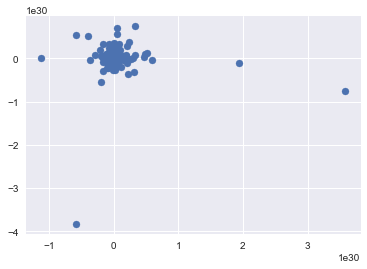

In [57]:
plt.scatter(crimes_tsne[:,0], crimes_tsne[:,1])

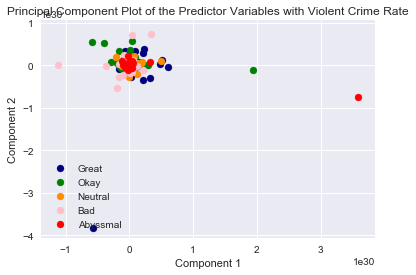

In [58]:
# PCA plot with labels for Violent Crime levels
colors = ['navy', 'green', 'darkorange', 'pink', 'red']

fig, ax = plt.subplots()
for i, color in  zip(crime_levels, colors):
        ax.scatter(crimes_tsne[Violent == i, 0],
                   crimes_tsne[Violent == i, 1], c = color, label=i)


ax.legend(loc = 3)
ax.grid(True)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title('Principal Component Plot of the Predictor Variables with Violent Crime Rate')


### In-Class Exercise 4 

- Get two tSNE components for the scaled predictors with log transformations using at least two different values for the hyperparameters
- Plot the observations in these components
- Plot the observations in these components with the violent crimes cut using the box plot statistics
- Plot the observations in these components with the nonviolent crimes cut using the box plot statistics
- Plot the observations in these components with one of the other response variables

So you can use linear PCAs to bring a hyperplane transformation to the data. In addition you can use non-linear tSNE transformations to look at the underlying nonlinear relationship in the data

### In-Class Exercise 5

- Insert a principal component and comparable t-SNE plot
- Compare and contrast these two plots using criteria of your choosing